Clustering of Stocks based on Financial Features

- The goal of this notebook is to take several financial features that correlate to a stock, and then cluster the stocks based on other stocks with similar data.

In [118]:
#importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


#load dataset
file_path = 'feature_analysis_data/2018_Financial_Data.csv'  
data = pd.read_csv(file_path)

In [119]:
#dataset exploration

print(f"Number of samples (rows): {data.shape[0]}")
print(f"Number of raw features (columns): {data.shape[1]}")

#missing values
missing_fraction = data.isnull().mean()  # Fraction of missing values per column
missing_fraction = missing_fraction[missing_fraction > 0]  # Filter columns with missing values
print(missing_fraction)

#number of categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
num_categorical = len(categorical_columns)

print(f"Number of categorical variables: {num_categorical}")

if num_categorical > 0:
    print("\nCategorical Columns:")
    print(categorical_columns)

Number of samples (rows): 4392
Number of raw features (columns): 225
Revenue                        0.010474
Revenue Growth                 0.031648
Cost of Revenue                0.042122
Gross Profit                   0.014572
R&D Expenses                   0.053962
                                 ...   
Asset Growth                   0.048725
Book Value per Share Growth    0.061703
Debt Growth                    0.060109
R&D Expense Growth             0.058971
SG&A Expenses Growth           0.056466
Length: 221, dtype: float64
Number of categorical variables: 2

Categorical Columns:
Index(['Unnamed: 0', 'Sector'], dtype='object')


Above - From our dataset exploration, we can see that there are 4392 stocks, and 225 features correlating to each stock. Examples of these features are Revenue, Revenue Growth, Gross Profit, and more. The majority of the features are numerical, with the two categorical ones being the ticker (label) of the stock, and the sector, which refers to what industry the stock is in.

Below - We use the categorical feature of 'Sector' to get a visualization of the data.

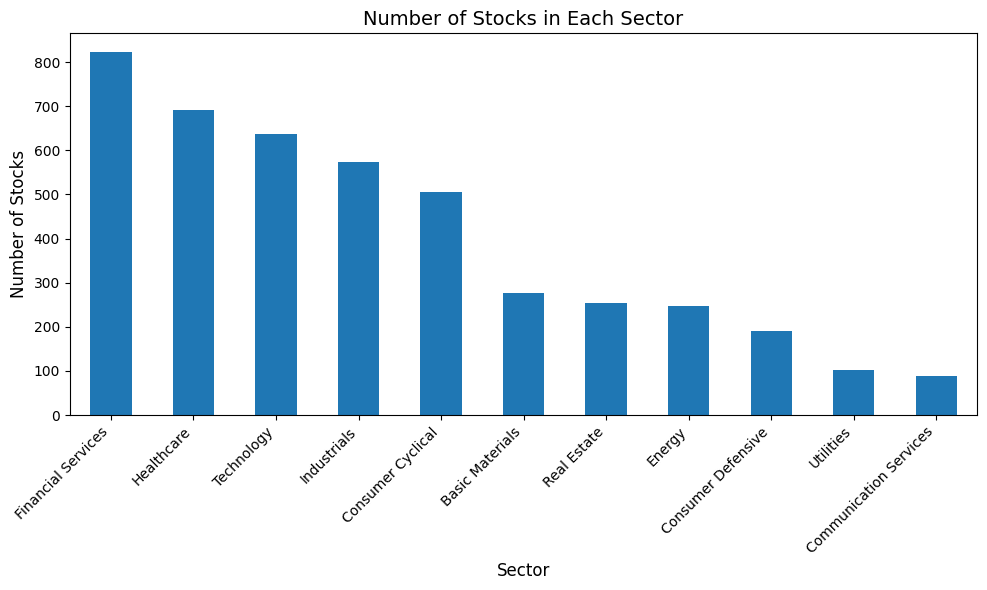

In [120]:
#plotting based on industry of stock

#count the number of stocks for each sector
sector_counts = data['Sector'].value_counts()

#plot
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar')
plt.title('Number of Stocks in Each Sector', fontsize=14)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


For our preprocessing, we first want to fix the first column (it is unnamed, so we call it 'stockTicker'). We also want to use only stocks in the S&P500, as 4000+ stocks is not feasible to perform clustering on. Lastly, we replace any NaN values with the mean of that column, a technique called mean imputation. Lastly, we further trim our analysis to stocks in the Technology sector, as while it would be interesting to see correlations in different fields, it results in a very mess k-means graph (with 400+ data points). We get more meaningful analysis from limiting it to one specific sector. To accomplish this, we use simple functions built into numpy.

In [121]:
#data preprocessing

#we see that the first column is unamed, but is refering to the stock ticker. We can fix that:
data.rename(columns={data.columns[0]: 'stockTicker'}, inplace=True)

#confirm this
print("Renamed Columns:")
print(data.columns[:5])  

#use only the stocks from the S&P 500
sp500_tickers_df = pd.read_csv("SP500.csv")  
sp500_tickers = sp500_tickers_df['Symbol'].tolist()
sp500_stocks = data[data['stockTicker'].isin(sp500_tickers)]
data = sp500_stocks

data.to_csv('filtered_data.csv', index=False)

total_nan = data.isna().sum().sum()
print(f"Total NaN values in the DataFrame(before imputation): {total_nan}")

#remove NaN values (two columns contain all NaN values), replace others with mean
data = data.drop(columns=['operatingCycle', 'cashConversionCycle'])

#fill NaN values with average value from column
data = data.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)
total_nan = data.isna().sum().sum()
print(f"Total NaN values in the DataFrame(after imputation): {total_nan}")

#fliter technology data and include numerical features only
technology_data = data[data['Sector'] == 'Technology']
technology_numerical_df = technology_data.select_dtypes(include=[np.number])

Renamed Columns:
Index(['stockTicker', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit'],
      dtype='object')
Total NaN values in the DataFrame(before imputation): 3113
Total NaN values in the DataFrame(after imputation): 0


For our feature extraction, we need to reduce the number of features present, as 220+ features isn't feasible to peform clustering on. Our methodology first involves finding 25 features that are most correlated with Gross Profit (as that is a useful metric for companies). We do this by computing the correlation matrix of all numerical features in the technology sector dataset, as this matrix represents the strength and direction of relationships between variables. Using the absolute value of the correlation values, we get these features. 

After this, we standardize the features using the StandardScaler function from sklearn, which makes sure each feature has a mean of 0 and a standard deviation. This makes sure that all data is represented equally, since they may have different scales and units. From here, we apply PCA, which transforms the data into a smaller number of uncorrelated components that get maximum variance in the dataset, while reducing it down to 2 dimensions so that we can graph them easier. This is done with the PCA function from sklearn. The result is the technology_pca_data, which we can use in ML methods.




In [122]:
#feature extraction

#calculate 25 features that are highly correlated with 'gross profit'
correlation_matrix = technology_numerical_df.corr()
gross_profit_correlation = correlation_matrix['Gross Profit']
top_correlated_features = gross_profit_correlation.abs().sort_values(ascending=False).iloc[1:26]
top_features = top_correlated_features.index.tolist()
print(top_features)

#standarize features
technology_top_features_df = technology_numerical_df[top_features]
scaler = StandardScaler()
technology_standardized_data = scaler.fit_transform(technology_top_features_df)

#perform PCA
pca = PCA(n_components=2)  
technology_pca_data = pca.fit_transform(technology_standardized_data)


['Revenue', 'Total assets', 'Operating Cash Flow', 'Depreciation & Amortization', 'R&D Expenses', 'EBITDA', 'Operating Expenses', 'Other Liabilities', 'Total current assets', 'SG&A Expense', 'Property, Plant & Equipment Net', 'Total non-current assets', 'Free Cash Flow', 'Tangible Asset Value', 'EBIT', 'Total current liabilities', 'Stock-based compensation', 'Earnings before Tax', 'Market Cap', 'Enterprise Value', 'Operating Income', 'Cost of Revenue', 'Capital Expenditure', 'Total shareholders equity', 'Net Income Com']


Our first machine learning technique is k-means clustering, chosen for its simplicity and efficiency in identifying natural groupings within the technology sector data. K-means works by partitioning the data into k clusters, where each cluster is represented by its centroid, and data points are assigned to the cluster with the nearest centroid to minimize within-cluster variance. We apply this using teh KMeans function from sklearn. To find a good k-value, we used the Elbow Method and Silhouette Analysis. The Elbow Method involves plotting the sum of squared distances (inertia) from each data point to its nearest cluster center for various k values, with the "elbow point" indicating the optimal k. Silhouette Analysis, on the other hand, evaluates how well-separated the clusters are, with higher silhouette scores signifying better-defined clusters. From these graphs, we observed that k=7 provided the best balance between compact and well-separated clusters. After determining k=7, we applied k-means to the PCA-transformed data and visualized the results using a scatter plot of the first two principal components, showing the seperation. Finally, we listed the stocks in each cluster, enabling further exploration of similarities and potential strategic groupings within the technology sector.

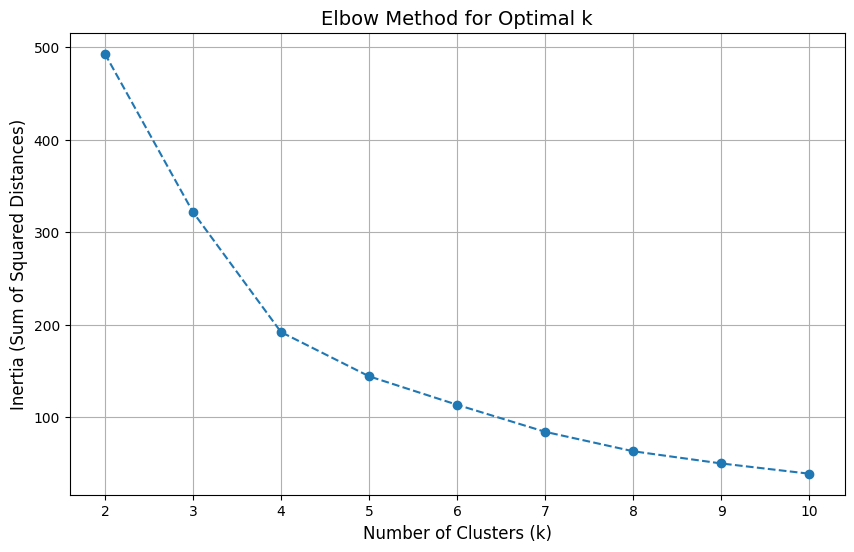

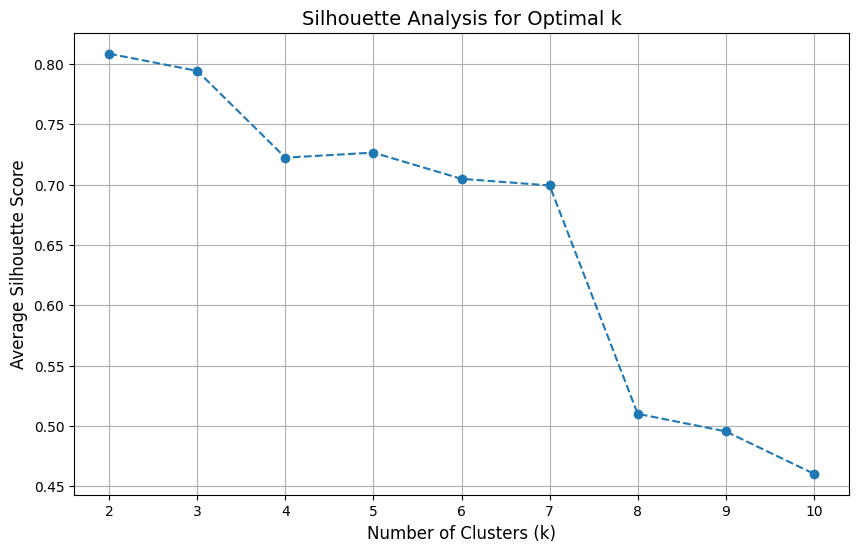

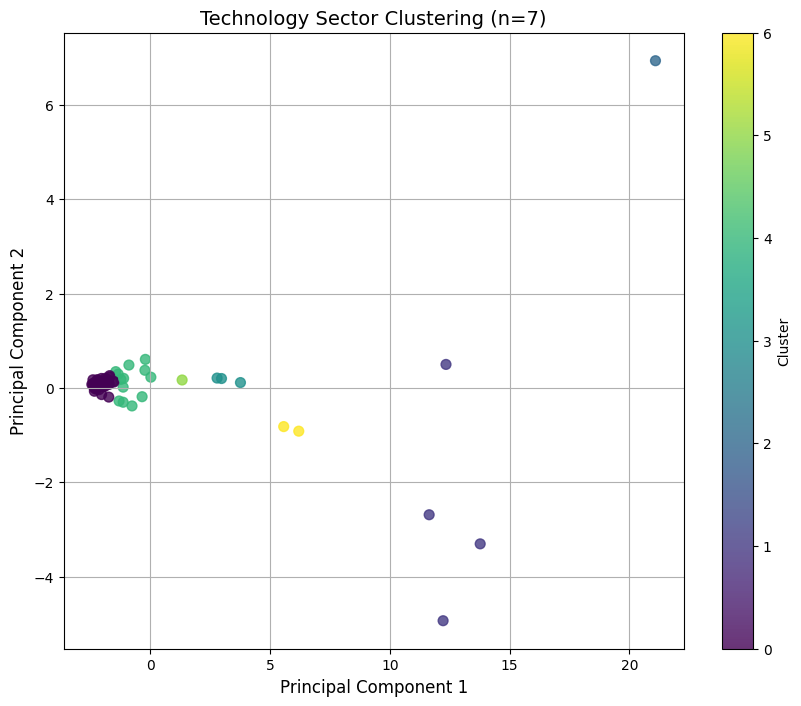


Stocks in Each Cluster:
Cluster 0: [AMD], [ATVI], [XRX], [ADSK], [IT], [STX], [LRCX], [FTV], [CTSH], [CTXS], [KLAC], [QRVO], [TEL], [EA], [INFO], [CERN], [AKAM], [CDNS], [NTAP], [JNPR], [MCHP], [INTU], [XLNX], [SWKS], [CA], [ADI], [VRSN], [EQIX], [FIS], [AYI], [MSI], [WHR], [FFIV], [FLIR], [APH], [WAT], [GRMN], [AME], [ANSS], [SNPS]
Cluster 1: [MSFT], [AMZN], [GOOGL], [GOOG]
Cluster 2: [AAPL]
Cluster 3: [ORCL], [CSCO], [IBM]
Cluster 4: [HPQ], [AVGO], [AMAT], [QCOM], [CRM], [NVDA], [WDC], [HPE], [TXN], [ACN], [GLW], [ADBE], [DXC]
Cluster 5: [MU]
Cluster 6: [INTC], [FB]


In [123]:
#ML technique 1 - k-means clustering

k_range = range(2, 11)  #k-values from 2-10
inertia = []  #sum of squared distance for the elbow method
silhouette_scores = []  #score for each k

#compute k-means for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  
    kmeans.fit(technology_standardized_data)
    inertia.append(kmeans.inertia_)  
    silhouette_scores.append(silhouette_score(technology_standardized_data, kmeans.labels_))

#plot elbow and silhouette analysis
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.grid()
plt.show()

#apply k-means clustering
n_clusters = 7  #using optimal k-value from graph
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
technology_clusters = kmeans.fit_predict(technology_pca_data)

#add labels
technology_data = technology_data.copy()  
technology_data['Cluster'] = technology_clusters

#plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    technology_pca_data[:, 0], 
    technology_pca_data[:, 1], 
    c=technology_clusters, 
    cmap='viridis', 
    s=50, 
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Technology Sector Clustering (n={n_clusters})', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid()
plt.show()


#print the list of stocks in each cluster
clustered_stocks = technology_data.groupby('Cluster')['stockTicker'].apply(list)
print("\nStocks in Each Cluster:")
for cluster, stocks in clustered_stocks.items():
    stock_list = ', '.join([f"[{stock}]" for stock in stocks])  # Format stocks as [stockTicker]
    print(f"Cluster {cluster}: {stock_list}")


Our second machine learning technique is hierarchical clustering, chosen for its ability to capture nested groupings and relationships within the technology sector data. Hierarchical clustering works by iteratively merging or splitting clusters based on the similarity of data points, creating a tree-like structure known as a dendrogram. We implemented this using the AgglomerativeClustering function from sklearn, specifying a linkage method of "Ward" to minimize the variance within clusters during the merging process. To determine the number of clusters, we set n=7 based on the cluster values from k-means. After applying hierarchical clustering to the PCA-transformed data, we visualized the results using a dendrogram. The scatter plot showed the separation of clusters, while the dendrogram provided insights into how the clusters were formed and their relationships. Finally, we listed the stocks in each cluster for further analysis, enabling comparisons and identifying natural groupings within the technology sector.


Stocks in Each Hierarchical Cluster:
Cluster 0: [AMD], [AMAT], [QCOM], [CRM], [ATVI], [XRX], [NVDA], [WDC], [HPE], [TXN], [ADSK], [IT], [GLW], [STX], [ADBE], [LRCX], [FTV], [CTSH], [CTXS], [KLAC], [QRVO], [TEL], [EA], [INFO], [CERN], [AKAM], [CDNS], [NTAP], [JNPR], [MCHP], [INTU], [XLNX], [SWKS], [CA], [ADI], [VRSN], [DXC], [EQIX], [FIS], [AYI], [MSI], [WHR], [FFIV], [FLIR], [APH], [WAT], [GRMN], [AME], [ANSS], [SNPS]
Cluster 1: [MU], [HPQ], [AVGO], [ACN]
Cluster 2: [AMZN], [GOOGL], [GOOG]
Cluster 3: [AAPL]
Cluster 4: [ORCL], [CSCO], [IBM]
Cluster 5: [MSFT]
Cluster 6: [INTC], [FB]


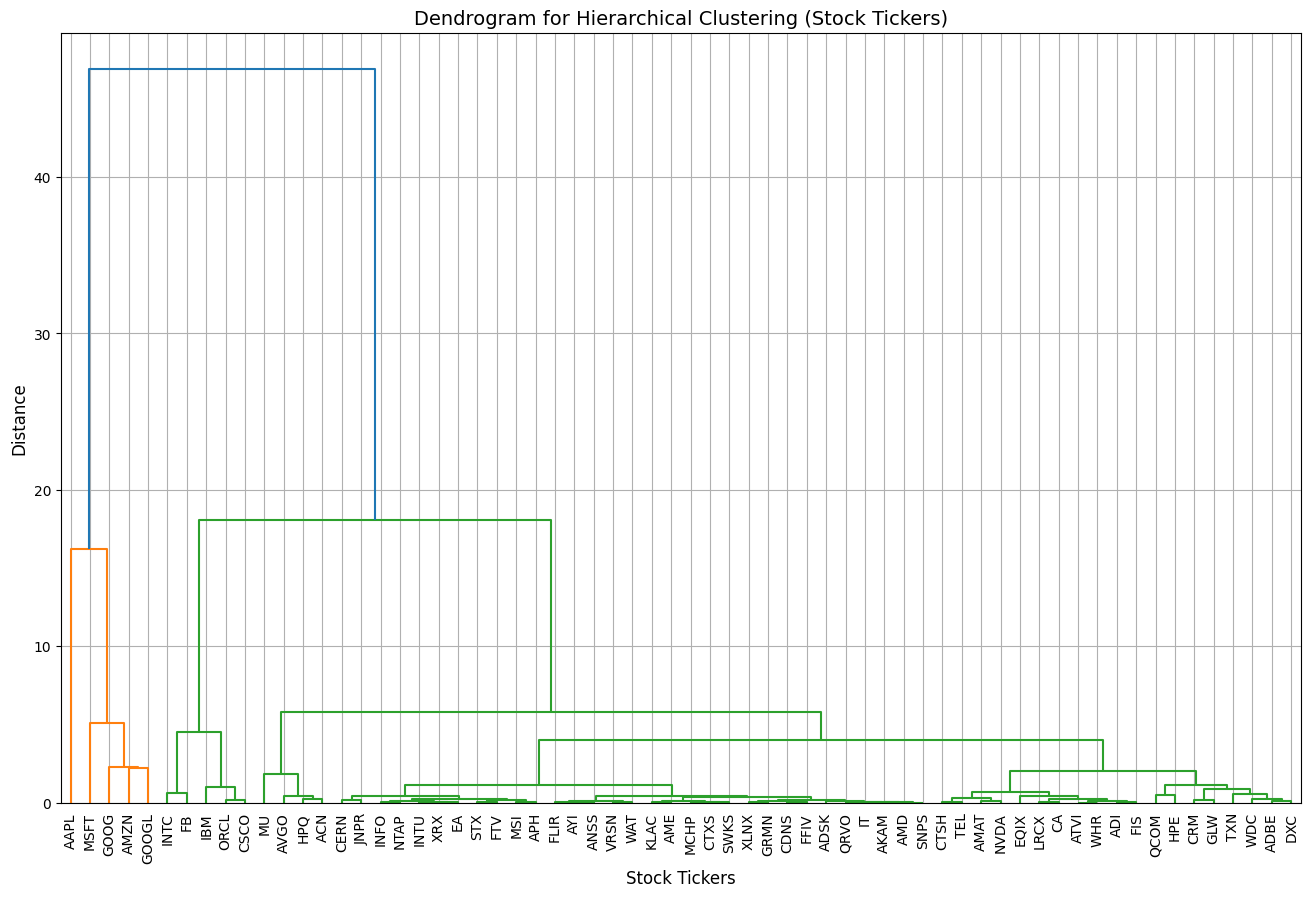

In [124]:
#ML technique 2 - hierarchal clustering
from sklearn.cluster import AgglomerativeClustering

#apply hierarchal clustering
n_clusters = 7  
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(technology_pca_data)

#add labels and group stocks by hierarchal clusters
technology_data['Hierarchical_Cluster'] = hierarchical_clusters
hierarchical_clustered_stocks = technology_data.groupby('Hierarchical_Cluster')['stockTicker'].apply(list)

#print list of stocks in each cluster
print("\nStocks in Each Hierarchical Cluster:")
for cluster, stocks in hierarchical_clustered_stocks.items():
    stock_list = ', '.join([f"[{stock}]" for stock in stocks])
    print(f"Cluster {cluster}: {stock_list}")

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

#linkage matrix for visual output
linkage_matrix = linkage(technology_pca_data, method='ward') 

#use tickers as labels
stock_labels = technology_data['stockTicker'].tolist()

#plot
plt.figure(figsize=(16, 10))
dendrogram(
    linkage_matrix,
    labels=stock_labels,  
    leaf_rotation=90,  
    leaf_font_size=10  
)
plt.title('Dendrogram for Hierarchical Clustering (Stock Tickers)', fontsize=14)
plt.xlabel('Stock Tickers', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid()
plt.show()



In our comparison of results, we see that there is a slightly higher silhouette score for hierarchical clustering, making it the better method. However, there is a pretty big issue in both clustering results, with that being the size imbalance of clusters. There is one cluster that the models have grouped the majority of stocks in, with the others seemingly being outliers. This mainly seems to be due to the fact that a lot of these outliers are the biggest tech companies currently (Apple, Meta, Microsoft, etc.). Potential improvement could be found by removing these stocks and finding clusters without them. However, one noteable cluster is that of [ORCL], [CSCO], and [IBM], present in both clustering algorithms, signifying further analysis of these three stocks. Overall, while we weren't able to find the best patterns between stocks, we can still use these results in a meaningful way, as demonstrated after the comparison.

In [125]:
#comparison

from sklearn.metrics import silhouette_score

# Silhouette score for k-means
kmeans_silhouette = silhouette_score(technology_pca_data, technology_data['Cluster'])
print(f"Silhouette Score for k-means: {kmeans_silhouette:.2f}")

# Silhouette score for hierarchical clustering
hierarchical_silhouette = silhouette_score(technology_pca_data, technology_data['Hierarchical_Cluster'])
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette:.2f}")

# Cluster sizes for k-means
kmeans_cluster_sizes = technology_data['Cluster'].value_counts()

# Cluster sizes for hierarchical clustering
hierarchical_cluster_sizes = technology_data['Hierarchical_Cluster'].value_counts()

# Display sizes
print("\nCluster Sizes for k-means:")
print(kmeans_cluster_sizes)

print("\nCluster Sizes for Hierarchical Clustering:")
print(hierarchical_cluster_sizes)


Silhouette Score for k-means: 0.60
Silhouette Score for Hierarchical Clustering: 0.65

Cluster Sizes for k-means:
Cluster
0    40
4    13
1     4
3     3
6     2
2     1
5     1
Name: count, dtype: int64

Cluster Sizes for Hierarchical Clustering:
Hierarchical_Cluster
0    50
1     4
4     3
2     3
6     2
3     1
5     1
Name: count, dtype: int64


Lastly, we see a pratical application of our clustering method. While it may not be as useful as we want it to be in finding hidden patterns, we can use it to create a portfolio in the technology sector.

In [126]:
#define clusters and their stocks 
#remove cluster 0 since it just groups everything together
clusters = {
    1: ['MU', 'HPQ', 'AVGO', 'ACN'],
    2: ['AMZN', 'GOOGL', 'GOOG'],
    3: ['AAPL'],
    4: ['ORCL', 'CSCO', 'IBM'],
    5: ['MSFT'],
    6: ['INTC', 'FB']
}

#calculate allocations
total_clusters = len(clusters)
cluster_weight = 1 / total_clusters


portfolio_allocation = {}
for cluster, stocks in clusters.items():
    stock_weight = cluster_weight / len(stocks)  
    for stock in stocks:
        portfolio_allocation[stock] = stock_weight

#display
print("\nPortfolio Allocation:")
for stock, weight in portfolio_allocation.items():
    print(f"{stock}: {weight:.4%}")





Portfolio Allocation:
MU: 4.1667%
HPQ: 4.1667%
AVGO: 4.1667%
ACN: 4.1667%
AMZN: 5.5556%
GOOGL: 5.5556%
GOOG: 5.5556%
AAPL: 16.6667%
ORCL: 5.5556%
CSCO: 5.5556%
IBM: 5.5556%
MSFT: 16.6667%
INTC: 8.3333%
FB: 8.3333%


Using clustering-based portfolio allocation raises several ethical concerns that should be addressed. One major issue is data bias, as clustering relies on historical data, which may include inaccuracies or systemic biases that favor larger or more established companies, potentially marginalizing smaller firms. Algorithmic bias is another concern, as the numerical similarity used to group stocks might overlook qualitative factors like governance or sustainability, leading to unfair treatment of certain sectors or companies. Additionally, the lack of context in purely financial clustering ignores ethical considerations, such as the societal impact of controversial industries, which could conflict with socially responsible investing principles.

Bibliography

- https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018

- https://www.geeksforgeeks.org/k-means-clustering-introduction/

- https://www.geeksforgeeks.org/hierarchical-clustering/